# Active Learning

Sometimes, we may just want to learn a black-box function, rather than optimizing it. This goal is known as active learning and corresponds to choosing query points that reduce our model uncertainty. This notebook demonstrates how to perform Bayesian active learning using Trieste.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf

np.random.seed(1793)
tf.random.set_seed(1793)

## Describe the problem

In this example, we will perform active learning for the scaled Branin function.

In [2]:
from trieste.objectives import scaled_branin
from util.plotting_plotly import plot_function_plotly
from trieste.space import Box

search_space = Box([0, 0], [1, 1])

fig = plot_function_plotly(scaled_branin, search_space.lower, search_space.upper, grid_density=20)
fig.update_layout(height=400, width=400)
fig.show()

We begin our Bayesian active learning from a two-point initial design built from a space-filling Halton sequence.

In [3]:
import trieste

observer = trieste.objectives.utils.mk_observer(scaled_branin)

num_initial_points = 4
initial_query_points = search_space.sample_halton(num_initial_points)
initial_data = observer(initial_query_points)

## Surrogate model

Just like in sequential optimization, we fit a surrogate Gaussian process model as implemented in GPflow to the initial data. The GPflow models cannot be used directly in our Bayesian optimization routines, so we build a GPflow's `GPR` model and pass it to the `GaussianProcessRegression` wrapper.

In [4]:
import gpflow
from trieste.models.gpflow.models import GaussianProcessRegression


def build_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.RBF(variance=variance, lengthscales=[2, 2])
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)

    return GaussianProcessRegression(gpr)


model = build_model(initial_data)

## Active learning using predictive variance

For our first active learning example, we will use a simple acquisition function known as `PredictiveVariance` which chooses points for which we are highly uncertain (i.e. the predictive posterior covariance matrix at these points has large determinant), as discussed in <cite data-cite="MacKay1992"/>. Note that this also implies that our model needs to have `predict_joint` method to be able to return the full covariance, and it's likely to be expensive to compute.

We will now demonstrate how to choose individual query points using `PredictiveVariance` before moving onto batch active learning. For both cases, we can utilize Trieste's `BayesianOptimizer` to do the active learning steps.


In [5]:
from trieste.acquisition.function import PredictiveVariance
from trieste.acquisition.optimizer import generate_continuous_optimizer
from trieste.acquisition.rule import EfficientGlobalOptimization

acq = PredictiveVariance()
rule = EfficientGlobalOptimization(
    builder=acq, optimizer=generate_continuous_optimizer()
)
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

To plot the contour of variance of our model at each step, we can set the `track_state` parameter to `True` in `bo.optimize()`, this will make Trieste record our model at each iteration.

In [6]:
bo_iter = 5
result = bo.optimize(bo_iter, initial_data, model, rule, track_state=True)

Optimization completed without errors


Then we can retrieve our final dataset from the active learning steps.

In [7]:
dataset = result.try_get_final_dataset()
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

Finally, we can check the performance of our `PredictiveVariance` active learning acquisition function by plotting the predictive variance landscape of our model. We can see how it samples regions for which our model is highly uncertain.

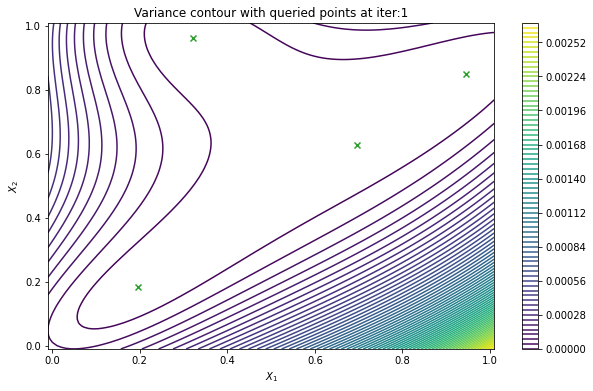

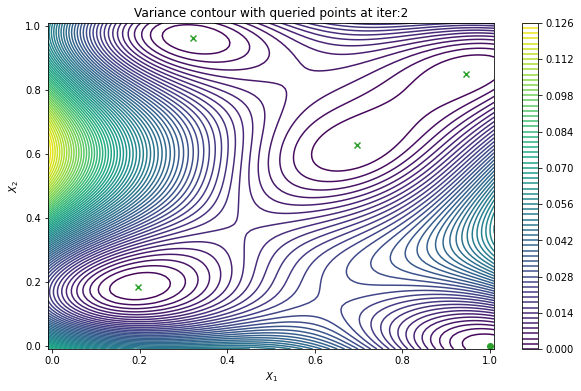

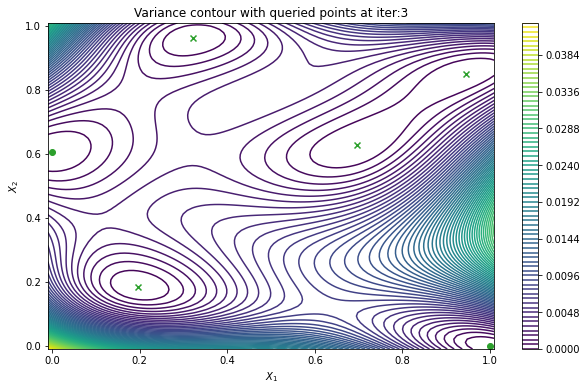

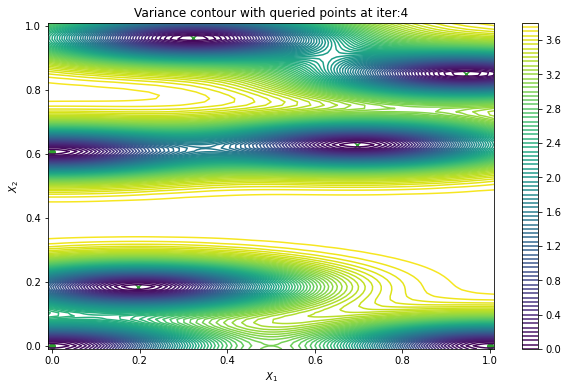

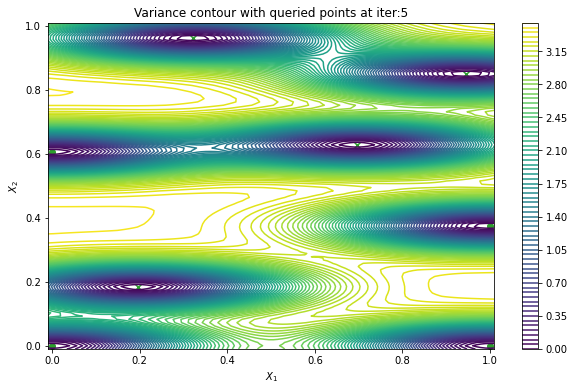

In [8]:
from util.plotting import plot_bo_points, plot_function_2d


def plot_active_learning_query(result, bo_iter, num_initial_points, query_points, num_query=1):

    for i in range(bo_iter):

        def pred_var(x):
            _, var = result.history[i].models["OBJECTIVE"].model.predict_f(x)
            return var

        _, ax = plot_function_2d(
            pred_var,
            search_space.lower - 0.01,
            search_space.upper + 0.01,
            grid_density=100,
            contour=True,
            colorbar=True,
            figsize=(10, 6),
            title=["Variance contour with queried points at iter:" + str(i + 1)],
            xlabel="$X_1$",
            ylabel="$X_2$",
        )

        plot_bo_points(
            query_points[: num_initial_points + (i * num_query)], ax[0, 0], num_initial_points
        )


plot_active_learning_query(result, bo_iter, num_initial_points, query_points)

## Batch active learning using predictive variance

For some cases, query several points at a time can be convenient by doing batch active learning. For this case, we must pass a num_query_points input to our `EfficientGlobalOptimization` rule. The drawback of the batch predictive variance is, it tends to query in high variance area less accurately, compared to the sequentially drawing one point at a time.

In [9]:
bo_iter = 5
num_query = 3
model = build_model(initial_data)
acq = PredictiveVariance()
rule = EfficientGlobalOptimization(
    num_query_points=num_query, builder=acq, optimizer=generate_continuous_optimizer()
)
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

result = bo.optimize(bo_iter, initial_data, model, rule, track_state=True)

Optimization completed without errors


After that, we can retrieve our final dataset.

In [10]:
dataset = result.try_get_final_dataset()
query_points = dataset.query_points.numpy()
observations = dataset.observations.numpy()

Now we can visualize the batch predictive variance using our plotting function.

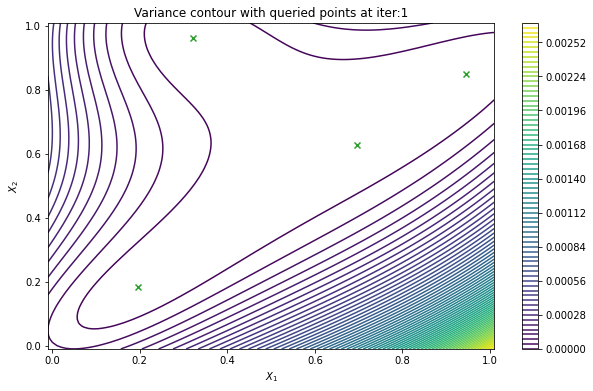

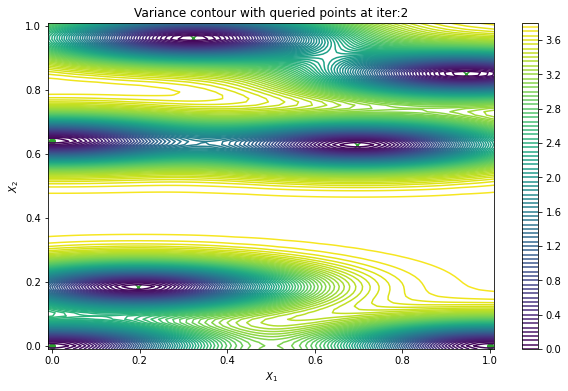

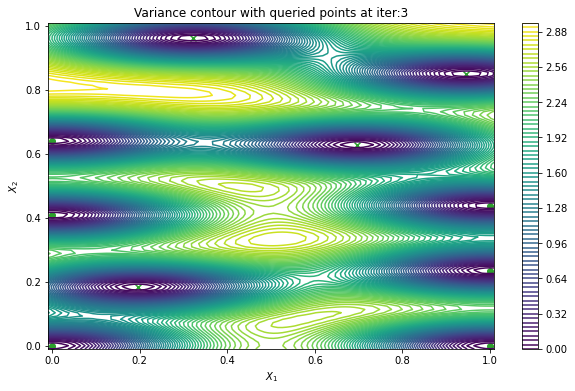

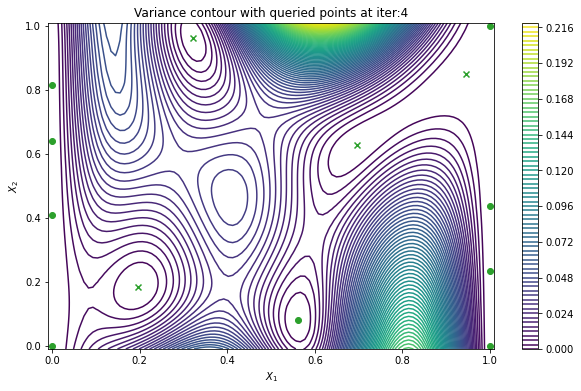

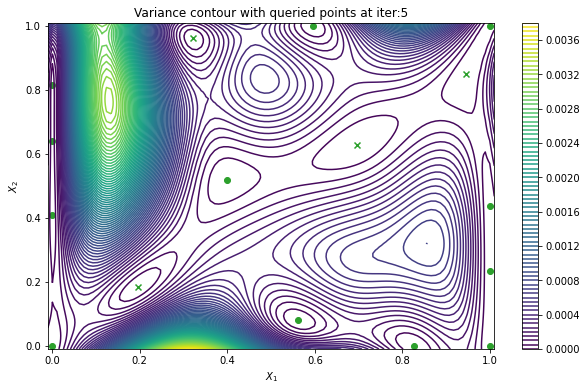

In [11]:
from util.plotting import plot_bo_points, plot_function_2d

plot_active_learning_query(result, bo_iter, num_initial_points, query_points, num_query)

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)